In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import os
from scipy.linalg import block_diag, solve_discrete_are
from PO.utils import make_diagonalizable_matrix, make_positive_semidefinite, plot_loss, plot_loss_sliding, compare_losses, make_diagonalizable_matrix_complex, get_hankel_new, run_multiple_runs, run_multiple_controllers,  plot_runs_with_mean, plot_multiple_controllers, plot_multiple_sliding_losses, run_multiple_models_with_params, plot_loss_comparison, plot_loss_comparison_with_ci


from PO.LQG.lqg import LQG  # new updated
from PO.GRC.grc import GRC # new updated
from PO.GRC.grc_STU import GRC_STU # new updated

from PO.DSC.dsc_new import DSC_New # new updated (changed after algo change)
from PO.DSC.dsc_PO_STU import DSC_PO_STU # new updated


In [3]:
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

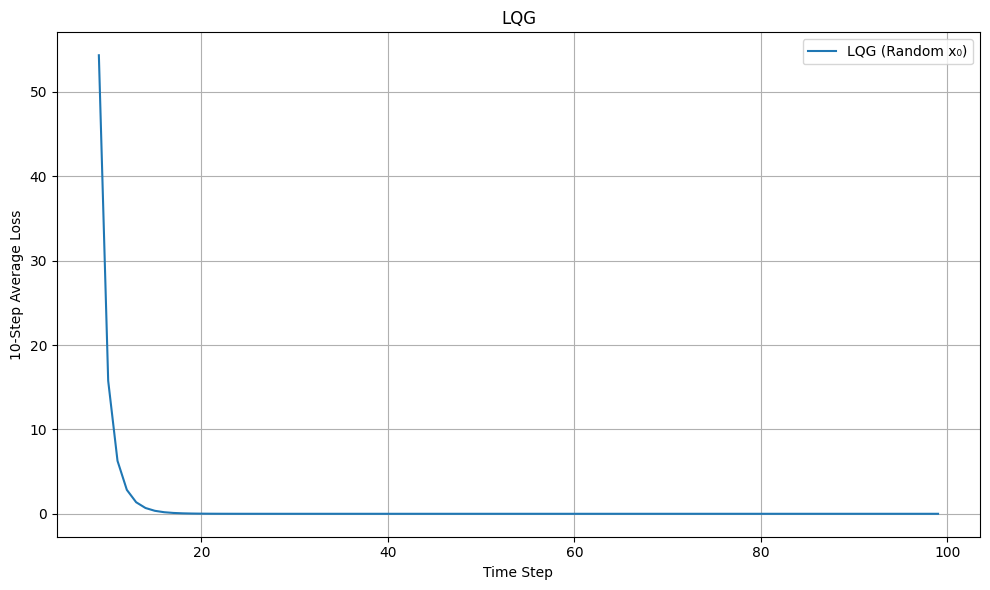

In [6]:
if __name__ == "__main__":
    # === CONFIGURATION ===
    torch.manual_seed(42)
    d = 25  # hidden state dimension
    p = 25  # observation dimension
    n = 5   # control dimension
    T = 100  # time horizon
    window = 10  # moving average window
    num_trials = 100
    add_noise = False  # toggle process noise
    random_initial_state = True  # toggle between random and zero initial state
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # === COST MATRICES ===
    Q_obs = torch.eye(p, device=device)
    R = torch.eye(n, device=device)
    W = torch.eye(d, device=device) * 0.1 if add_noise else torch.zeros((d, d), device=device)
    V = torch.eye(p, device=device) * 1e-5
    
    # === GENERATE LDS ===
    # Create eigenvalues
    eigvals = torch.linspace(0.2, 0.8, d, device=device)
    
    # Create random orthogonal matrix through QR decomposition
    Q_eig, _ = torch.linalg.qr(torch.randn(d, d, device=device))
    A = Q_eig @ torch.diag(eigvals) @ Q_eig.t()
    B = torch.randn(d, d, device=device) @ torch.randn(d, n, device=device)
    C = torch.randn(p, d, device=device)
    
    # Ensure observability
    def is_observable(A, C):
        """Check if the system is observable by checking rank of observability matrix"""
        obs_matrix = []
        for i in range(d):
            obs_matrix.append(C @ torch.matrix_power(A, i))
        obs_matrix = torch.cat(obs_matrix, dim=0)
        rank = torch.linalg.matrix_rank(obs_matrix)
        return rank == d
    
    # Regenerate C until the system is observable
    while not is_observable(A, C):
        C = torch.randn(p, d, device=device)
    
    # Convert matrices to CPU numpy arrays for LQG initialization
    A_np = A.cpu().numpy()
    B_np = B.cpu().numpy()
    C_np = C.cpu().numpy()
    Q_obs_np = Q_obs.cpu().numpy()
    R_np = R.cpu().numpy()
    W_np = W.cpu().numpy()
    V_np = V.cpu().numpy()
    
    # Create LQG controller
    lqg_controller = LQG(A=A_np, B=B_np, C=C_np, Q=Q_obs_np, R=R_np, Q_noise=W_np, R_noise=V_np, T=T)
    
    controller_device = lqg_controller.device
    
    # Run simulations
    # With control
    lqg_costs = lqg_controller.run(
        initial_state=torch.randn(d, 1, device=controller_device) if random_initial_state else torch.zeros(d, 1, device=controller_device),
        add_noise=add_noise,
        use_control=True,
        num_trials=num_trials
    )
    lqg_controller.losses = lqg_costs
    
    # Without control
    zero_costs = lqg_controller.run(
        initial_state=torch.randn(d, 1, device=controller_device) if random_initial_state else torch.zeros(d, 1, device=controller_device),
        add_noise=add_noise,
        use_control=False,
        num_trials=num_trials
    )
    
    # Create a temporary controller to hold zero costs for plotting
    zero_controller = LQG(
        A=A_np,
        B=B_np,
        C=C_np,
        Q=Q_obs_np,
        R=R_np,
        Q_noise=W_np,
        R_noise=V_np,
        T=T
    )
    zero_controller.losses = zero_costs
    
    # Plot results
    label = lambda b: 'Random x₀' if b else 'x₀ = 0'
    
    # Option to plot both LQG and Zero Input
    """
    plot_loss_comparison(
        [lqg_controller, zero_controller],
        [f'LQG ({label(random_initial_state)})', f'Zero Input ({label(random_initial_state)})'],
        f"LQG vs Zero Input (Noise={'On' if add_noise else 'Off'})",
        window_size=window
    )
    """
    
    # Plot just LQG performance
    plot_loss_comparison(
        [lqg_controller],
        [f'LQG ({label(random_initial_state)})'],
        f"LQG",
        window_size=window
    )

Running LQG controller with random initial state
Process noise: On
Running GRC controller with h=3, lr=0.01


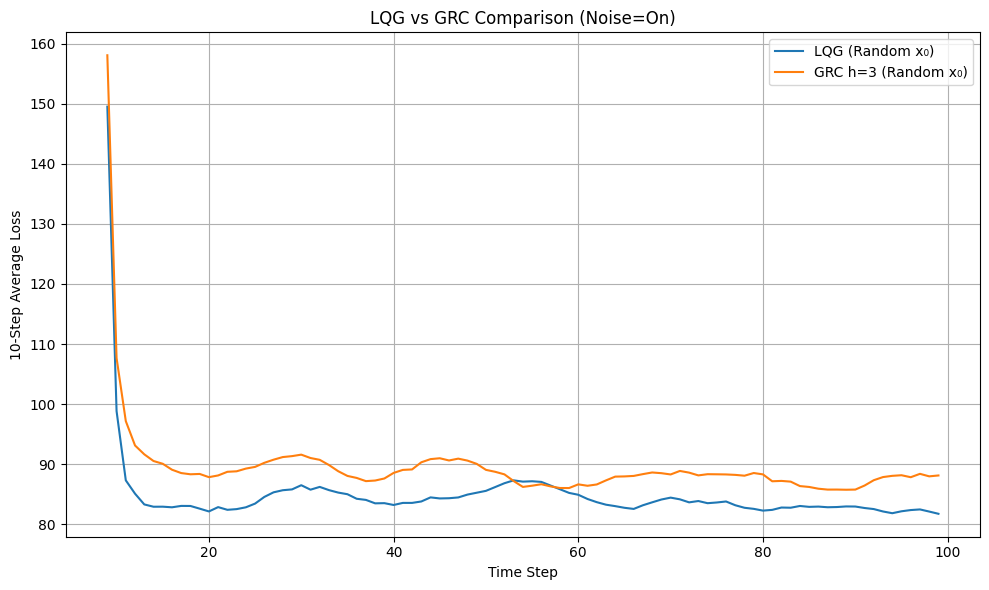

In [ ]:
if __name__ == "__main__":
    # === CONFIGURATION ===
    torch.manual_seed(42)
    d = 25  # hidden state dimension
    p = 25  # observation dimension
    n = 5   # control dimension
    T = 100  # time horizon
    window = 10  # moving average window
    num_trials = 100
    add_noise = True  # toggle process noise
    random_initial_state = True  # toggle between random and zero initial state
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # GRC parameters
    h = 3  # history length
    lr = 0.01  # learning rate
    
    # === COST MATRICES ===
    Q_obs = torch.eye(p, device=device)
    R = torch.eye(n, device=device)
    W = torch.eye(d, device=device) * 0.1 if add_noise else torch.zeros((d, d), device=device)
    V = torch.eye(p, device=device) * 1e-1
    
    # === GENERATE LDS ===
    # Create eigenvalues
    eigvals = torch.linspace(0.2, 0.8, d, device=device)
    
    # Create random orthogonal matrix through QR decomposition
    Q_eig, _ = torch.linalg.qr(torch.randn(d, d, device=device))
    A = Q_eig @ torch.diag(eigvals) @ Q_eig.t()
    B = torch.randn(d, d, device=device) @ torch.randn(d, n, device=device)
    C = torch.randn(p, d, device=device)
    
    # Ensure observability
    def is_observable(A, C):
        """Check if the system is observable by checking rank of observability matrix"""
        obs_matrix = []
        for i in range(d):
            obs_matrix.append(C @ torch.matrix_power(A, i))
        obs_matrix = torch.cat(obs_matrix, dim=0)
        rank = torch.linalg.matrix_rank(obs_matrix)
        return rank == d
    
    # Regenerate C until the system is observable
    while not is_observable(A, C):
        C = torch.randn(p, d, device=device)
    
    # Convert matrices to CPU numpy arrays for controller initialization
    A_np = A.cpu().numpy()
    B_np = B.cpu().numpy()
    C_np = C.cpu().numpy()
    Q_obs_np = Q_obs.cpu().numpy()
    R_np = R.cpu().numpy()
    W_np = W.cpu().numpy()
    V_np = V.cpu().numpy()
    
    # Create LQG controller
    lqg_controller = LQG(A=A_np, B=B_np, C=C_np, Q=Q_obs_np, R=R_np, Q_noise=W_np, R_noise=V_np,T=T)
    
    # Create GRC controller with same system matrices
    grc_controller = GRC(A=A_np, B=B_np,C=C_np,Q=Q_obs_np,R=R_np,Q_noise=W_np,R_noise=V_np,h=h,T=T,lr=lr)
    
    # Ensure initial state is on the correct device and the same for both controllers
    controller_device = lqg_controller.device
    initial_state = torch.randn(d, 1, device=controller_device) if random_initial_state else torch.zeros(d, 1, device=controller_device)
    
    print(f"Running LQG controller with {'random' if random_initial_state else 'zero'} initial state")
    print(f"Process noise: {'On' if add_noise else 'Off'}")
    
    # Run LQG simulation with control
    lqg_costs = lqg_controller.run(
        initial_state=initial_state.clone(),
        add_noise=add_noise,
        use_control=True,
        num_trials=num_trials
    )
    lqg_controller.losses = lqg_costs
    
    print(f"Running GRC controller with h={h}, lr={lr}")
    
    # Run GRC simulation with same initial state
    grc_costs = grc_controller.run(
        initial_state=initial_state.clone(),
        add_noise=add_noise,
        use_control=True,
        num_trials=num_trials
    )
    grc_controller.losses = grc_costs
     
    # Create the labels
    label = lambda b: 'Random x₀' if b else 'x₀ = 0'

    
    # Plot just LQG vs GRC for clearer comparison
    plot_loss_comparison(
        [lqg_controller, grc_controller],
        [f'LQG ({label(random_initial_state)})', 
         f'GRC h={h} ({label(random_initial_state)})'],
        f"LQG vs GRC Comparison (Noise={'On' if add_noise else 'Off'})",
        window_size=window #save_path="PO/figures/results/grc_v_lqg_new_gauss3.png"
    )

In [8]:
mean_lqg, lower_lqg, upper_lqg = plot_loss_comparison_with_ci(
    [lqg_controller, grc_controller],
    [f'LQG ({label(random_initial_state)})', f'GRC h={h} ({label(random_initial_state)})'],
    f"LQG vs GRC Comparison (Noise={'On' if add_noise else 'Off'})",
    window_size=window,
    confidence=0.95  # 95% confidence interval
    #save_path="PO/figures/results/grc_v_lqg_new_gauss3_with_ci.png"
)

NameError: name 'plot_loss_comparison_with_ci' is not defined